# Анализ данных по продажам

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime as dt

In [113]:
data = pd.read_csv("data_sales.csv", parse_dates=['DateTime'], dayfirst=True)

In [114]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3833790 entries, 0 to 3833789
Data columns (total 6 columns):
 #   Column             Dtype         
---  ------             -----         
 0   DateTime           datetime64[ns]
 1   StoreID            object        
 2   GoodsID            object        
 3   Sale               int64         
 4   ABC_analise_goods  object        
 5   Rating             int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 175.5+ MB


In [115]:
data.head()

,DateTime,StoreID,GoodsID,Sale,ABC_analise_goods,Rating
0,2019-02-01 19:58:36,IZ-000034,00047364,1,C,3
1,2019-02-01 19:58:36,IZ-000034,00152527,1,C,3
2,2019-02-01 19:58:36,IZ-000034,00152528,1,C,3
3,2019-02-01 19:58:36,IZ-000034,00041576,1,A,4
4,2019-02-01 19:58:36,IZ-000034,00041577,1,C,4


In [116]:
data.columns = ['datetime', 'store_id', 'item_id', 'sales', 'abc_type', 'rating']

In [117]:
data['year'] = data.datetime.dt.year
data['month'] = data.datetime.dt.month
data['day'] = data.datetime.dt.day
data['time'] = data.datetime.dt.time

In [118]:
print(f"Всего продано: {data.sales.sum()} psc")
print(f"Количество магазинов: {data.store_id.nunique()}")
print(f"Всего наименований товаров: {data.item_id.nunique()}")
print(f"Пропущенные значения в колонке abc_type: {data.abc_type.isna().sum()}")
print(f"Уникальные значения рейтинга: {data.rating.unique()}")

Всего продано: 3833790 psc
Количество магазинов: 58
Всего наименований товаров: 73939
Пропущенные значения в колонке abc_type: 109691
Уникальные значения рейтинга: [3 4 2 5 6 1 7]


In [119]:
data.loc[:,'abc_type'] = data.abc_type.fillna('D')

In [120]:
data.abc_type.isna().sum()

0

In [121]:
sales_by_type = data.groupby('abc_type').agg({'sales':'sum'}).reset_index()

In [122]:
sales_by_type

,abc_type,sales
0,A,1705139
1,B,880611
2,C,1138349
3,D,109691


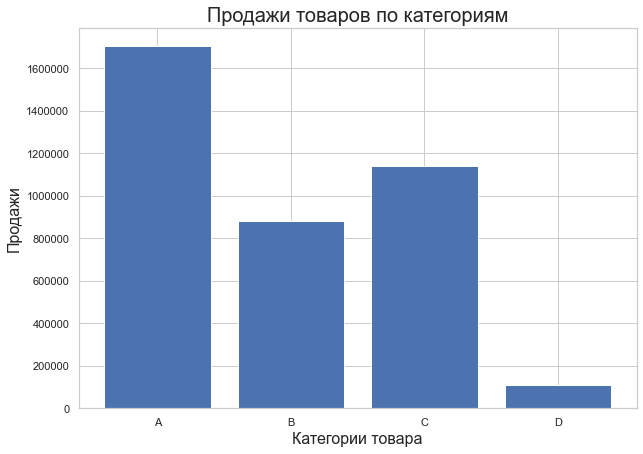

In [123]:
fig, ax = plt.subplots(figsize=(10,7))
ax.bar(x = sales_by_type.abc_type, height = sales_by_type.sales)
plt.ylabel('Продажи', fontsize=16)
plt.ticklabel_format(axis='y', style='plain')
plt.xlabel('Категории товара',fontsize=16)
plt.title('Продажи товаров по категориям',fontsize=20)
plt.show()

Из-за небольшого опыта в продажах, каких-то выводов сделать не могу. Нужно подробнее изучить данную область. 

In [124]:
stores = data.groupby(['store_id','item_id']).agg({'sales':'sum'}).reset_index()

In [125]:
stores.head()

,store_id,item_id,sales
0,IZ-000001,00000035,18
1,IZ-000001,00000036,10
2,IZ-000001,00000037,17
3,IZ-000001,00000038,17
4,IZ-000001,00000039,6


In [126]:
stores_gr = stores.groupby('store_id').agg({'item_id':'count', 'sales':'sum'}).reset_index()
stores_gr.columns = ['store_id', 'items_count', 'sales']

In [127]:
stores_gr.head()

,store_id,items_count,sales
0,IZ-000001,12555,81117
1,IZ-000002,14915,99754
2,IZ-000003,15729,101145
3,IZ-000004,15241,118985
4,IZ-000005,15362,121912


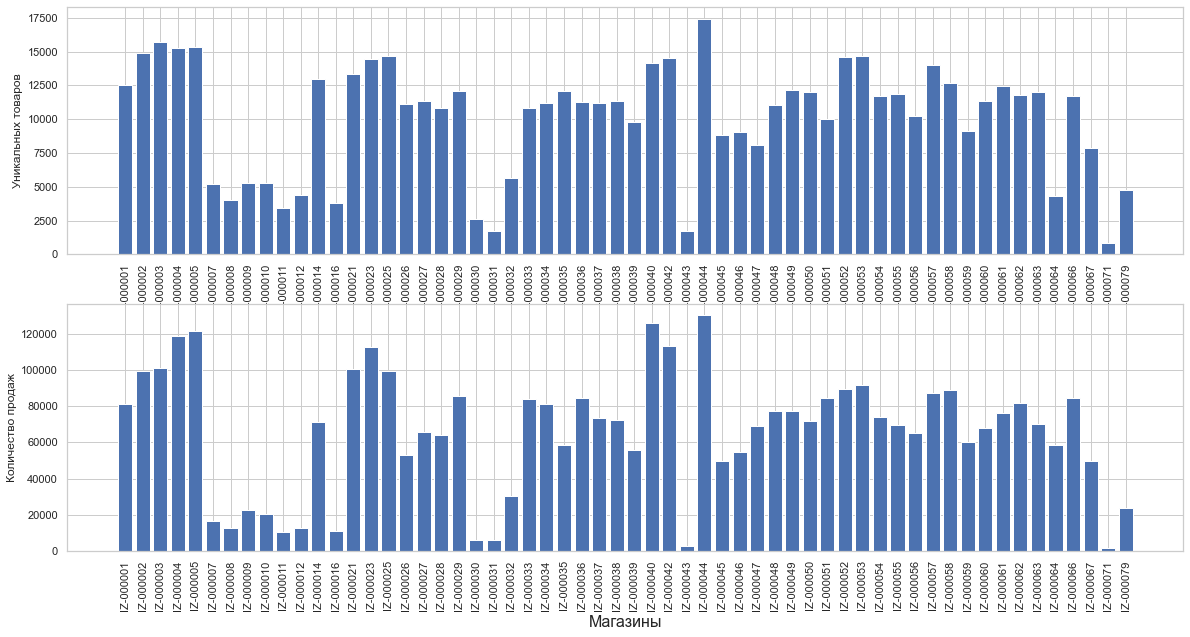

In [128]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(20,10))
# plt.title('Продажи и количество уникальных товаров',fontsize=20)

ax[0].bar(x = stores_gr.store_id, height = stores_gr.items_count, label='Количество уникальных товаров')
ax[0].set_ylabel('Уникальных товаров')
ax[1].bar(x = stores_gr.store_id, height = stores_gr.sales, label='Количество продаж')
ax[1].set_ylabel('Количество продаж')

plt.setp(ax[0].get_xticklabels(), rotation=90, ha='center')
plt.setp(ax[1].get_xticklabels(), rotation=90, ha='center')
plt.ticklabel_format(axis='y', style='plain')
plt.xlabel('Магазины',fontsize=16)

plt.show()

По графикам видно, что в каждом магазине количество уникальных товаров различное. Полный список доступных в товаров в магазине из данных получить не получится, но можно предположить, что раз товар продавался в этом магазине, то он скорее всего либо есть в наличии, либо будет доставлен в ближайшую доставку. Так же можно заметить, что есть зависимость между количеством проданных уникальных товаров и количеством продаж в магазине. Либо продается больше товара из-за его разнообразия, либо в магазины, расположенные в местах с хорошей проходимостью, доставляют больше уникальных товаров. 
Для построения рекомендаций можно попробовать для каждого магазина проверять доступный в данном магазине товар, и рекомендовать из доступных наименований.

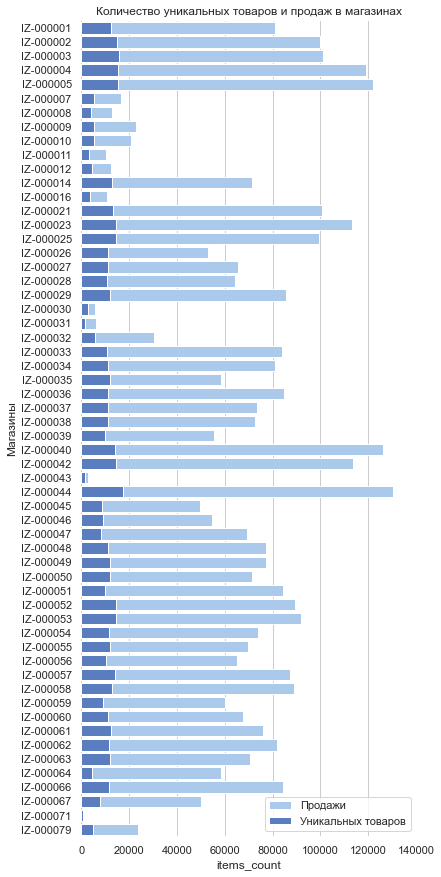

In [129]:
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(6, 15))

sns.set_color_codes("pastel")
sns.barplot(x="sales", y="store_id", data=stores_gr,
            label="Продажи", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="items_count", y="store_id", data=stores_gr,
            label="Уникальных товаров", color="b")

# Add a legend and informative axis label
ax.legend(loc="lower right", frameon=True)
ax.set(xlim=(0, 140000), ylabel="Магазины",
      title='Количество уникальных товаров и продаж в магазинах')
sns.despine(left=True, bottom=True)

In [133]:
sales_by_seasons = data.groupby(pd.Grouper(key="datetime", freq="MS")).agg({'sales':'sum'}).reset_index()

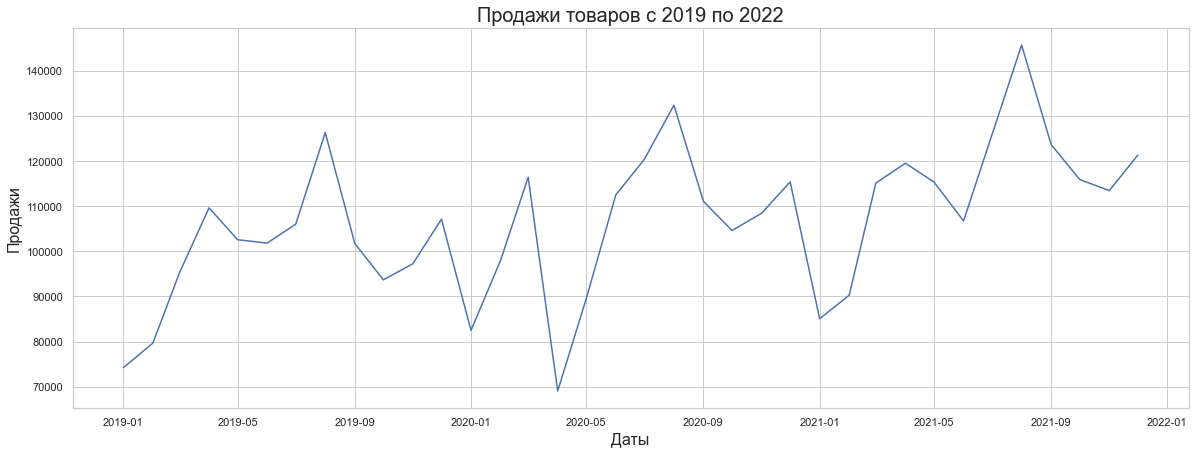

In [149]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(sales_by_seasons.datetime, sales_by_seasons.sales)
plt.ylabel('Продажи', fontsize=16)
plt.ticklabel_format(axis='y', style='plain')
plt.xlabel('Даты',fontsize=16)
plt.title('Продажи товаров с 2019 по 2022',fontsize=20)
plt.show()

На графике можно проследить линию тренда, хоть она и не явная. Так же видно сезонность, повышение продаж в охотничьи сезоны, и спад в межсезонье. Но так же в апреле 2020 есть выброс, т.к. в 2020 весений охотничий сезон не открывали в большинстве регионов РФ из-за коронавирусных ограничений. Так же виден рост продаж в декабре и спад в январе, что может говорить о том, что в декабре покупают подарки на новый год. В феврале так же повышаются продажи, можно предположить, что для подарков на 23 февраля или для подготовки к весеннему охотничьему сезону. В марте начинается не массовый охот.сезон. Основной пик продаж приходится на апрель и август, открываются самые массовые и доступные виды охоты. 
Выделяя сезонность в рекомендациях можно использовать наиболее подходящие категории товаров, например, декабрь и февраль - теплая зимняя одежда, патроны большого калибра, подарочные сертификаты, апрель-май - дробь, утепленная непромокаемая одежда, теплые палатки, обогреватели для палаток, манки, август-сентрябрь - дробь, репеленты, летние палатки, легкая непромокаемая одежда, аммуниция для охотничьих собак и т.д. Это только примеры. На предоставленных данных точность будет не высокая, из-за выбросов, вызванных геополитическими и социальными событиями, но со временем, веделение сезонности в рекомендациях может дать хороший прирост продаж. 

Для товаров для рыбалки сезонность может не дать ожидаемого эффекта, но, предполагаю, что у рыбалки тоже есть сезонные запросы по типу наживок, типу удочек, одежды и атрибутов для рыбалки. Для более детального анализа нужно подробнее изучить предметную область. 

In [137]:
sales_by_days = data.groupby(pd.Grouper(key="datetime", freq="D")).agg({'sales':'sum'}).reset_index()
sales_by_days.columns = ['date', 'sales']

In [148]:
sales_by_days[sales_by_days.sales > 10000]

,date,sales
370,2020-01-07,11184
408,2020-02-14,11002


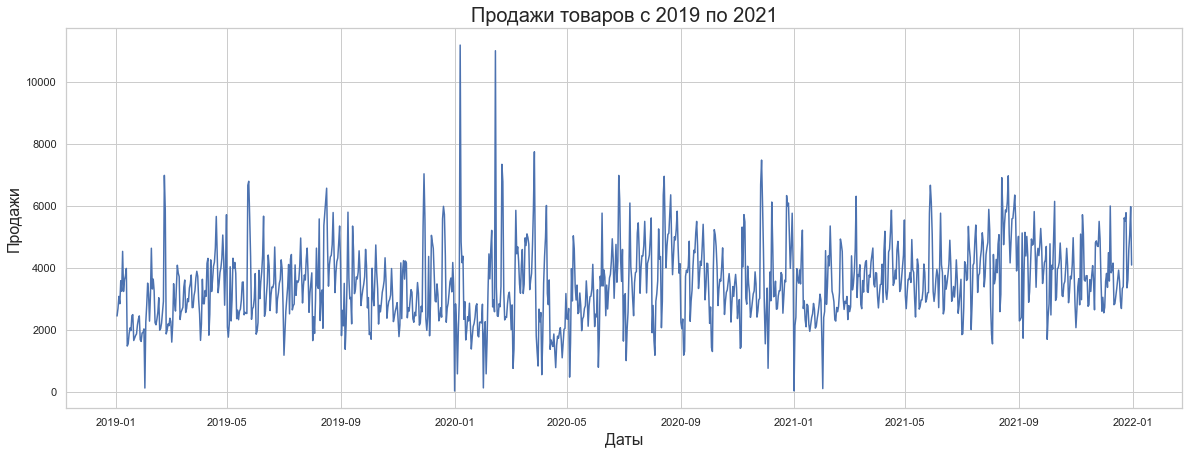

In [138]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(sales_by_days.date, sales_by_days.sales)
plt.ylabel('Продажи', fontsize=16)
plt.ticklabel_format(axis='y', style='plain')
plt.xlabel('Даты',fontsize=16)
plt.title('Продажи товаров с 2019 по 2021',fontsize=20)
plt.show()

Предыдущий график был сглажен, чтобы уменьшить влияние выбросов. Особенно интересны выбросы от 2020-01-07 и 2020-02-14. Нужно их проверить. Либо это ошибка в данных, либо были какие-то акции или распродажи.